In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
import scipy

In [3]:
# set random seed for debugging purpose, need to turn off when perform monte carlo
# np.random.seed(42)

In [4]:
# plots
def gain(w):
    """Return the power as a function of azimuthal angle, phi."""
    phi = np.linspace(0, 2*np.pi, 1000)
    psi = 2*np.pi * 1 / 2 * np.cos(phi)
    j = np.arange(len(w))
    A = np.sum(w[j] * np.exp(j * 1j * psi[:, None]), axis=1)
    g = np.abs(A)**2
    return phi, g

def get_directive_gain(g, minDdBi=-20):
    """Return the "directive gain" of the antenna array producing gain g."""
    DdBi = 10 * np.log10(g / np.max(g))
    return np.clip(DdBi, minDdBi, None)

## channel generation

In [59]:
def rand_angles(M):
    return np.random.randint(0, 180, M)/180*np.pi # 0->180deg

def rand_distances(M):
    return np.random.randint(1000, 2500, M) # 50-250m

def generate_channels_LOS(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    r = np.arange(N)
    h_array_LOS = [np.exp(-2j*np.pi*distances[i]/lambda_)*np.exp(-1j*2*(np.pi*r/2)*np.cos(angles[i])).reshape((N, 1)) for i in range(M)]
    h_array_LOS_norm_QoS = []
    h_array_LOS_norm_MaxMin = []
    
    for i in range(M):
        # normalization QoS
        h_i_norm_QoS = h_array_LOS[i]/np.sqrt(rho_min_qos_sigma2)
        h_array_LOS_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_array_LOS[i]/sigma_i
        h_array_LOS_norm_MaxMin.append(h_i_norm_MaxMin)
    
    # generate H_i matrix
    H_array_LOS = []
    H_array_LOS_norm_QoS = []
    H_array_LOS_norm_MaxMin = []
    for i in range(M):
        H_array_LOS.append(np.matmul(h_array_LOS[i], np.conjugate(h_array_LOS[i]).T))
        H_array_LOS_norm_QoS.append(np.matmul(h_array_LOS_norm_QoS[i], np.conjugate(h_array_LOS_norm_QoS[i]).T))
        H_array_LOS_norm_MaxMin.append(np.matmul(h_array_LOS_norm_MaxMin[i], np.conjugate(h_array_LOS_norm_MaxMin[i]).T))
        
    return h_array_LOS, h_array_LOS_norm_QoS, h_array_LOS_norm_MaxMin, H_array_LOS, H_array_LOS_norm_QoS, H_array_LOS_norm_MaxMin
        
def generate_channels(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        # h_i = np.exp(-2j*np.pi*distances[i]/lambda_)*(np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)))
        h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
        # h_i = (np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain and no scale var
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin

def generate_channels_comparison_MaxMin_QoS(angles, distances, lambda_, N, M, rho_min_qos_sigma2=1, sigma_i=1):
    # channel generation
    h_array = []
    h_array_norm_QoS = []
    h_array_norm_MaxMin = []
    for i in range(M):
        # complex normal with zero-mean, unit-variance
        # h_i = np.random.normal(loc=0, scale=np.sqrt(2)/2, size=(N, 2)).view(np.complex128)
        # h_i = np.exp(-2j*np.pi*distances[i]/lambda_)*(np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)))
        # h_i = np.sqrt(2)/2*(np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain
        # h_i = (np.random.randn(N) + 1j*np.random.randn(N)).reshape((N, 1)) # no baseband gain and no scale var
        h_i = (16*np.random.randn(N)+4 + 1j*(16*np.random.randn(N)+4)).reshape((N, 1)) # follows exp from paper h = randn(4,16) + j*randn(4,16)
        h_array.append(h_i)

        # normalization QoS
        h_i_norm_QoS = h_i/np.sqrt(rho_min_qos_sigma2)
        h_array_norm_QoS.append(h_i_norm_QoS)

        # normalization MaxMin
        h_i_norm_MaxMin = h_i/sigma_i
        h_array_norm_MaxMin.append(h_i_norm_MaxMin)

    # generate H_i matrix
    H_array = []
    H_array_norm_QoS = []
    H_array_norm_MaxMin = []
    for i in range(M):
        H_array.append(np.matmul(h_array[i], np.conjugate(h_array[i]).T))
        H_array_norm_QoS.append(np.matmul(h_array_norm_QoS[i], np.conjugate(h_array_norm_QoS[i]).T))
        H_array_norm_MaxMin.append(np.matmul(h_array_norm_MaxMin[i], np.conjugate(h_array_norm_MaxMin[i]).T))
        
    return h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin
    

## Randomization

In [6]:
def recover_w_SVD(W_opt):
    v, d = np.linalg.eig(W_opt)
    w_opt = d[:,0]
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randA(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))

def recover_w_randB(W_opt):
    e_js = np.random.uniform(0, 2*np.pi, W_opt.shape[0]).reshape((W_opt.shape[0], 1))
    e = np.cos(e_js) + 1j*np.sin(e_js)
    w_opt = np.matmul(np.sqrt(np.diag(np.diag(W_opt))), e)
    return w_opt.reshape((W_opt.shape[0], 1))
    
def recover_w_randC(W_opt):
    v, d = np.linalg.eig(W_opt)
    # rand e
    e = np.sqrt(2)/2*(np.random.randn(W_opt.shape[0]) + 1j*np.random.randn(W_opt.shape[0])).reshape((N, 1))
    
    Sigma_sqrt = np.sqrt(np.diag(v))
    w_opt = np.matmul(np.matmul(d, Sigma_sqrt), e)
    return w_opt.reshape((W_opt.shape[0], 1))


## Check violation

In [7]:
def check_violation(w, h):
    scale_factor = 1
    constraint = np.abs(np.dot(np.conjugate(h).T, w))[0][0]**2
    # print(constraint)
    violate = constraint < 1
    if violate:
        return np.sqrt(1.0/constraint), constraint
    return scale_factor, constraint

def get_min_scale_factor(w, h_array):
    s = np.min(np.abs(np.matmul(np.conjugate(w).T, h_array)).ravel())
    if s < 1:
        return 1/s
    return 1

def calc_norm2(w):
    # return np.sqrt(np.abs(np.dot(np.conjugate(w).T, w))[0][0])
    return np.linalg.norm(w)

def get_min_snr(w, h_array):
    min_snr = np.inf
    for h in h_array:
        snr = np.abs(np.dot(np.conjugate(h).T, w))**2
        # print(snr)
        min_snr = np.min([min_snr, snr])
    return min_snr

In [8]:
N = 8 # number of transmit antennas
M = 16 # number of mobile users
# P = 1 # transmit power

lambda_ = 0.375 # carrier wavelength
antenna_sep = 1/2 # antenanna separation half wavelength

# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

In [9]:
angles = rand_angles(M)
distances = rand_distances(M)

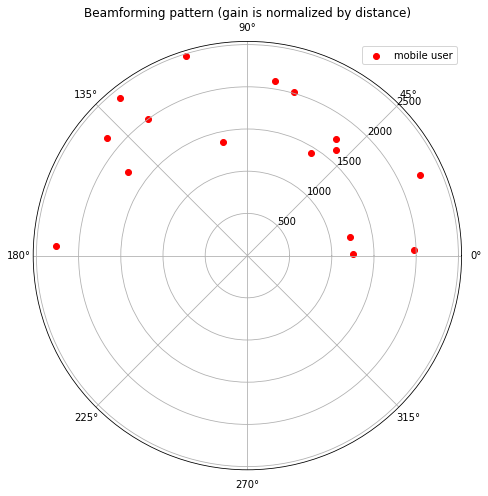

In [10]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='polar')
ax.scatter(angles, distances, color="red", label="mobile user")
# ax.set_rticks([0, 50, 100, 200, 250])
ax.set_rlabel_position(45)
plt.title("Beamforming pattern (gain is normalized by distance)")
plt.legend()
plt.tight_layout()
plt.show()

## Compare MaxMin and QoS

In [1]:
# QoS
rho_min_qos_sigma2 = 1 #rho_min_i * sigma_i^2 = 1 for all i

# Max-Min
sigma_i = 1 

# power
P = 1

In [12]:
N=4
M=16
P=1

In [60]:
print("Solving N/M = {}/{}".format(N, M))

best_t = []
best_t_maxmin = []
best_t_qos = []

# Monte Carlo 1000 runs
for k in tqdm.tqdm(range(300)):
    # regenerate channel, no path loss
    h_array, h_array_norm_QoS, h_array_norm_MaxMin, H_array, H_array_norm_QoS, H_array_norm_MaxMin = generate_channels_comparison_MaxMin_QoS(None, None, lambda_, N, M, rho_min_qos_sigma2=rho_min_qos_sigma2, sigma_i=sigma_i)

    ### MAXMIN SDR ###
    W = cp.Variable((N, N), hermitian=True)
    t = cp.Variable(1)

    constraints = [W >> 0]
    constraints += [cp.real(cp.trace(W)) == P] # power constraint
    constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_MaxMin[i]))) >= t for i in range(M)]

    prob = cp.Problem(cp.Maximize(t),
                 constraints)
    opt = prob.solve(solver="MOSEK", verbose=False)
    W_opt = W.value

    best_t.append(t.value[0])

    max_minSNR = -np.inf
    for i in range(30*N*M):
        # recover randomization
        w_randA = recover_w_randA(W_opt)
        w_randB = recover_w_randB(W_opt)
        w_randC = recover_w_randC(W_opt)

        # scale to norm P
        w_randA /= np.linalg.norm(w_randA)/np.sqrt(P)
        w_randB /= np.linalg.norm(w_randB)/np.sqrt(P)
        w_randC /= np.linalg.norm(w_randC)/np.sqrt(P)

        max_minSNR_tmp = np.max([np.min(abs(np.matmul(np.conjugate(w_randA).T, h_array_norm_MaxMin)).ravel()),
                                 np.min(abs(np.matmul(np.conjugate(w_randB).T, h_array_norm_MaxMin)).ravel()),
                                 np.min(abs(np.matmul(np.conjugate(w_randC).T, h_array_norm_MaxMin)).ravel())
                               ])
        max_minSNR = np.max([max_minSNR, max_minSNR_tmp])
    best_t_maxmin.append(max_minSNR**2)
    ### END MAXMIN SDR ###

    ### QoS SDR ###
    W = cp.Variable((N, N), hermitian=True)

    # need to use cp.real since cp.trace will give imaginary part = 0j, which will break the code
    constraints = [W >> 0]
    constraints += [cp.real(cp.trace(cp.matmul(W, H_array_norm_QoS[i]))) >= 1 for i in range(M)]

    prob = cp.Problem(cp.Minimize( cp.real(cp.trace(W))),
                 constraints)
    opt = prob.solve(solver="MOSEK", verbose=False)
    W_opt = W.value

    w_best = None
    ubpb_best = np.inf
    ubpb = []
    for i in range(30*N*M):
    # for i in range(10000):
        # recover randomization
        w_randA = recover_w_randA(W_opt)
        w_randB = recover_w_randB(W_opt)
        w_randC = recover_w_randC(W_opt)

        scale_factor_randA = get_min_scale_factor(w_randA, h_array_norm_QoS)
        scale_factor_randB = get_min_scale_factor(w_randB, h_array_norm_QoS)
        scale_factor_randC = get_min_scale_factor(w_randC, h_array_norm_QoS)

        w_randA *= scale_factor_randA
        w_randB *= scale_factor_randB
        w_randC *= scale_factor_randC

        w_l = [w_randA, w_randB, w_randC]
        norm_l = [np.linalg.norm(w_randA)**2, np.linalg.norm(w_randB)**2, np.linalg.norm(w_randC)**2]

        w_min = w_l[np.argmin(norm_l)]
        ubpb.append(np.linalg.norm(w_min)**2/opt)

        if ubpb[-1] < ubpb_best:
            w_best = w_min
            ubpb_best = ubpb[-1]
    w_best_qos = w_best/np.linalg.norm(w_best)/np.sqrt(P) # scale to norm P
    max_minSNR_tmp = np.min(abs(np.matmul(np.conjugate(w_best_qos).T, h_array_norm_QoS)).ravel())
    best_t_qos.append(max_minSNR_tmp**2)
    ### END QoS SDR ###


print("upper bound =", np.mean(best_t))
print("maxmin =", np.mean(best_t_maxmin))
print("qos =", np.mean(best_t_qos))
    

Solving N/M = 4/16


100%|█████████████████████████████████████████| 300/300 [03:42<00:00,  1.35it/s]

upper bound = 396.44944345288116
maxmin = 276.25989419956005
qos = 275.58884509102063


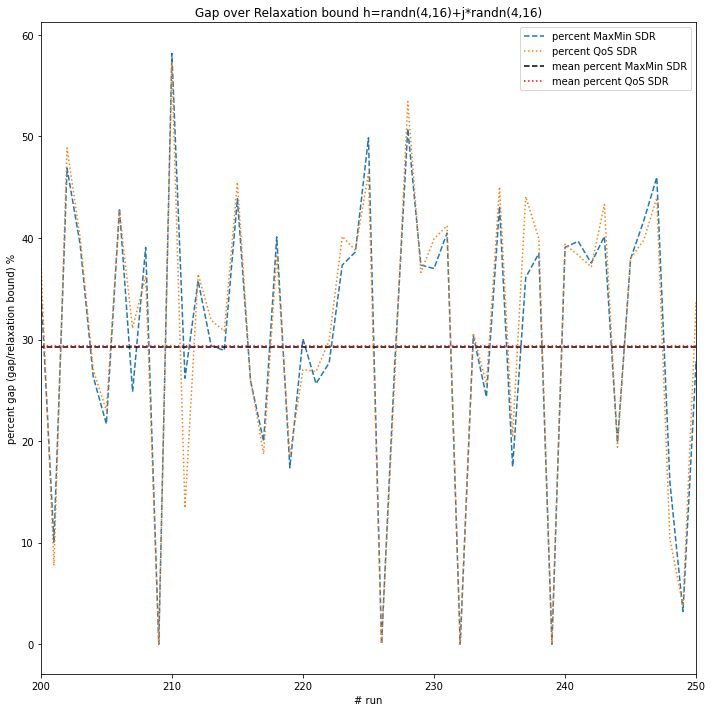

In [67]:
fig = plt.figure(figsize=(10,10))
plt.plot(100*((np.array(best_t) - np.array(best_t_maxmin))/np.array(best_t)), linestyle="dashed", label="percent MaxMin SDR")
plt.plot(100*((np.array(best_t) - np.array(best_t_qos))/np.array(best_t)), linestyle="dotted", label="percent QoS SDR")
# plt.hline(np.mean(100*(np.array(best_t)-np.array(best_t_qos)), label="mean MaxMin SDR"))
plt.hlines(100*np.mean((np.array(best_t) - np.array(best_t_maxmin))/np.array(best_t)), 0, 300, color="black", linestyle="dashed", label="mean percent MaxMin SDR")
plt.hlines(100*np.mean((np.array(best_t) - np.array(best_t_qos))/np.array(best_t)), 0, 300, color="r", linestyle="dotted", label="mean percent QoS SDR")
plt.xlabel("# run")
plt.ylabel("percent gap (gap/relaxation bound) %")
plt.title("Gap over Relaxation bound h=randn(4,16)+j*randn(4,16)")
plt.xlim(200,250)
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# fig.savefig("figures/fig_comparison_qos_maxmin_{}user_{}an.png".format(M, N))